In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install rfpimp
!{sys.executable} -m pip install yellowbrick
!{sys.executable} -m pip install eli5
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!{sys.executable} -m jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: pandas-profiling[notebook] in d:\anaconda\lib\site-packages (2.11.0)


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from rfpimp import plot_importances
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import GridSearchCV

from eli5.sklearn import PermutationImportance
from matplotlib import pyplot


%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_seq_items', 1000)

In [3]:
# Define all the csv input data files
people = pd.read_csv("PEOPLE.csv")
subj_pref = pd.read_csv("C_SUBJECT_PREF.csv")
region_pref = pd.read_csv("C_REGION_PREF.csv")
regions = pd.read_csv("REGIONS_DESC.csv")

In [4]:
# Merge all the data into 1 data frame (for easier operations)
all_data = pd.merge(people, subj_pref, how='outer', on="PERSONID")
region_data = pd.merge(region_pref, regions, how='outer', on="REGION_CODE")
all_data = pd.merge(all_data, region_data, how='outer', on="PERSONID")

len(all_data.PERSONID.unique())

9913

In [5]:
all_data.head(5)

,PERSONID,Applicant_Pool,UNIV_Selectivity,UNIV_Major,Candidate_Strength,Low_IncomeComm_Ex,Low_IncomeComm_Ex_L,Mission_KNWL_ALNMT,FastApp,ESSAY_Length,ESSAY_T1,ESSAY_T2,ESSAY_T3,ESSAY_T4,ESSAY_T5,ESSAY_T6,ESSAY_T7,ESSAY_T8,ESSAY_T9,ESSAY_T10,MATCH_REGION_CODE,MATCH_Subject,MATCH_is_home_region,MATCH_is_UNIV_Region,MATCH_is_Current_Region,MATCH_District,MATCH_School,MATCH_School_Type,MATCH_Grade_Level,MATCH_Y1_subject_group,OUTCOME_1_Confirmed,OUTCOME_2_StartTeaching,OUTCOME_3_Complet_Y1,OC_Satisfaction_Y1,OUTCOME_4_Complet_Y2,OC_Satisfaction_Y2,MATCH_Region_Pref_Level,MATCH_Region_Pref_Rank,MATCH_Subject_Prefer,SUBJECT_Pref,SUBJECT_Pref_Level,SUBJECT_Teach_Mapping,REGION_CODE,REGION_Pref_Level,REGION_Pref_Rank,CERT_COST,RENT_2_shared,RENT_1_single,Y1_MIN_SAL,Y1_MAX_SAL,Y2_MIN_SAL,Y2_MAX_SAL,SEX_RATIO_ M,AGE_20_24,AGE_25_29,AGE_30_34,AGE_35_39,AGE_40_44,AGE_45_49,RACE_NON_WHITE,RACE_Two_or_more,Population_size,ED_ATN_Less_9G,ED_ATN_HS_p,ED_ATN_Bachelor_p,TEMP_MAX_JAN,TEMP_MAX_FEB,TEMP_MAX_MAR,TEMP_MAX_APR,TEMP_MAX_MAY,TEMP_MAX_JUN,TEMP_MAX_JUL,TEMP_MAX_AUG,TEMP_MAX_SEP,TEMP_MAX_OCT,TEMP_MAX_NOV,TEMP_MAX_DEC,TEMP_MAX_ANN,TEMP_MIN_JAN,TEMP_MIN_FEB,TEMP_MIN_MAR,TEMP_MIN_APR,TEMP_MIN_MAY,TEMP_MIN_JUN,TEMP_MIN_JUL,TEMP_MIN_AUG,TEMP_MIN_SEP,TEMP_MIN_OCT,TEMP_MIN_NOV,TEMP_MIN_DEC,TEMP_MIN_ANN,SUN_PERCT_JAN,SUN_PERCT_FEB,SUN_PERCT_MAR,SUN_PERCT_APR,SUN_PERCT_MAY,SUN_PERCT_JUN,SUN_PERCT_JUL,SUN_PERCT_AUG,SUN_PERCT_SEP,SUN_PERCT_OCT,SUN_PERCT_NOV,SUN_PERCT_DEC,SUN_PERCT_ANN,DEM_perc_16,DEM_perc_20,GOP_perc_16,GOP_perc_20,delta_turnout,ECON_GINI,TOURISTS,WALKSCORE,BIKESCORE,TRANISTCORE
0,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,411.0,2.0,1.0,0.0,700.0,1150.0,36000.0,48000.0,36000.0,48000.0,92.7,5.7,6.9,7.3,7.1,6.4,5.9,0.4265,0.0195,small,3.6,91.2,38.2,62.1,65.4,71.8,78.2,85.2,89.5,91.2,91.2,87.5,80.0,71.8,64.4,78.2,44.7,48.0,53.5,60.0,68.1,73.5,75.3,75.3,72.0,62.6,53.5,46.9,61.2,48.0,52.0,56.0,62.0,59.0,67.0,61.0,59.0,61.0,70.0,57.0,54.0,58.0,0.509,0.539,0.449,0.443,1.101,0.4942,0.007167,59.0,66.0,44.0
1,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,419.0,3.0,5.0,0.0,100.0,1600.0,47500.0,52500.0,47500.0,52500.0,94.5,5.7,6.6,6.7,6.3,6.7,6.9,0.2999,0.0263,big city,7.1,90.8,34.4,76.4,78.1,80.3,83.2,87.0,89.5,90.9,91.0,89.3,86.2,81.7,77.9,84.3,59.9,62.3,64.9,68.3,72.9,76.0,77.3,77.4,76.5,73.5,68.1,63.0,70.1,68.0,68.0,74.0,79.0,73.0,70.0,77.0,72.0,69.0,72.0,63.0,66.0,70.0,0.637,0.534,0.341,0.461,1.203,0.5076,0.004167,78.0,65.0,57.0
2,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,432.0,3.0,3.0,2608.0,900.0,1725.0,37218.0,49100.0,37218.0,49100.0,97.7,4.5,5.8,6.3,7.9,6.3,6.2,0.6638,0.2113,very small,4.7,95.2,24.2,80.1,80.2,81.2,82.7,84.6,87.0,87.9,88.7,88.6,86.7,83.9,81.2,84.4,66.3,66.1,67.7,69.4,70.9,73.4,74.5,75.1,74.4,73.4,71.4,68.3,70.9,59.0,62.0,68.0,63.0,66.0,67.0,71.0,73.0,75.0,67.0,60.0,56.0,65.0,0.615,0.625,0.316,0.357,1.411,0.4333,0.000300,23.0,23.0,36.0
3,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,400.0,1.0,2.0,2300.0,720.0,1200.0,44000.0,47000.0,44000.0,47000.0,93.5,6.4,7.3,7.0,7.1,6.8,7.2,0.4778,0.0276,bi

In [6]:
# Data cleaning
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'More selective', 'More Selective',  all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Least Selective', 1, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Less Selective', 2, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Selective', 3, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'More Selective', 4, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Most Selective', 5, all_data.UNIV_Selectivity)

all_data.UNIV_Selectivity = all_data.UNIV_Selectivity.astype(int)
all_data.MATCH_is_home_region = all_data.MATCH_is_home_region.astype(int)
all_data.MATCH_is_UNIV_Region = all_data.MATCH_is_UNIV_Region.astype(int)
all_data.MATCH_is_Current_Region = all_data.MATCH_is_Current_Region.astype(int)

all_data.Low_IncomeComm_Ex = np.where(all_data.Low_IncomeComm_Ex == 'Y', 1,  all_data.Low_IncomeComm_Ex)
all_data.Low_IncomeComm_Ex = np.where(all_data.Low_IncomeComm_Ex == 'N', 0,  all_data.Low_IncomeComm_Ex)
all_data.Low_IncomeComm_Ex.fillna(all_data.Low_IncomeComm_Ex.mean(), inplace=True)

all_data.Low_IncomeComm_Ex_L = np.where(all_data.Low_IncomeComm_Ex_L == 'LEVEL1', 1,  all_data.Low_IncomeComm_Ex_L)
all_data.Low_IncomeComm_Ex_L = np.where(all_data.Low_IncomeComm_Ex_L == 'LEVEL2', 2,  all_data.Low_IncomeComm_Ex_L)
all_data.Low_IncomeComm_Ex_L = np.where(all_data.Low_IncomeComm_Ex_L == 'LEVEL3', 3,  all_data.Low_IncomeComm_Ex_L)
all_data.Low_IncomeComm_Ex_L.fillna(all_data.Low_IncomeComm_Ex_L.mean(), inplace=True)

all_data.Candidate_Strength.fillna(all_data.Candidate_Strength.mean(), inplace=True)
all_data.Mission_KNWL_ALNMT.fillna(all_data.Mission_KNWL_ALNMT.mean(), inplace=True)

all_data.MATCH_Region_Pref_Level.fillna(all_data.MATCH_Region_Pref_Level.mean(), inplace=True)
all_data.MATCH_Region_Pref_Rank.fillna(all_data.MATCH_Region_Pref_Rank.mean(), inplace=True)

all_data.REGION_Pref_Level.fillna(all_data.REGION_Pref_Level.mean(), inplace=True)
all_data.REGION_Pref_Rank.fillna(all_data.REGION_Pref_Rank.mean(), inplace=True)

all_data.ED_ATN_Bachelor_p.fillna(all_data.ED_ATN_Bachelor_p.mean(), inplace=True)

In [7]:
# Adding my own columns
all_data['is_subject_matched'] = np.where(all_data.SUBJECT_Pref == all_data.MATCH_Subject, 1 ,0)
all_data['is_positive_exp'] = np.where((all_data.OC_Satisfaction_Y2 >= 4.0) & (all_data.OC_Satisfaction_Y1 >= 4.0) & (all_data.OUTCOME_4_Complet_Y2 == 1), 1 ,0)

all_data['home_eol'] = (all_data.WALKSCORE + all_data.BIKESCORE + all_data.TRANISTCORE) / 300
all_data['home_eol'].fillna(all_data.home_eol.mean(), inplace=True)

all_data['is_region_match'] = np.where((all_data.MATCH_is_home_region == 1) & (all_data.MATCH_is_UNIV_Region == 1) & (all_data.MATCH_is_Current_Region == 1), 1 ,0)

all_data['region_match_level'] = np.where(all_data.MATCH_is_home_region == 1, 1, 0)
all_data['region_match_level'] = np.where(all_data.MATCH_is_UNIV_Region == 1, all_data.region_match_level+1, 0)
all_data['region_match_level'] = np.where(all_data.MATCH_is_Current_Region == 1, all_data.region_match_level+1, 0)

all_data['is_perfect_candidate'] = np.where((all_data.Candidate_Strength > 0.8) & (all_data.ED_ATN_Bachelor_p > 0.6), 1, 0)

<AxesSubplot:>

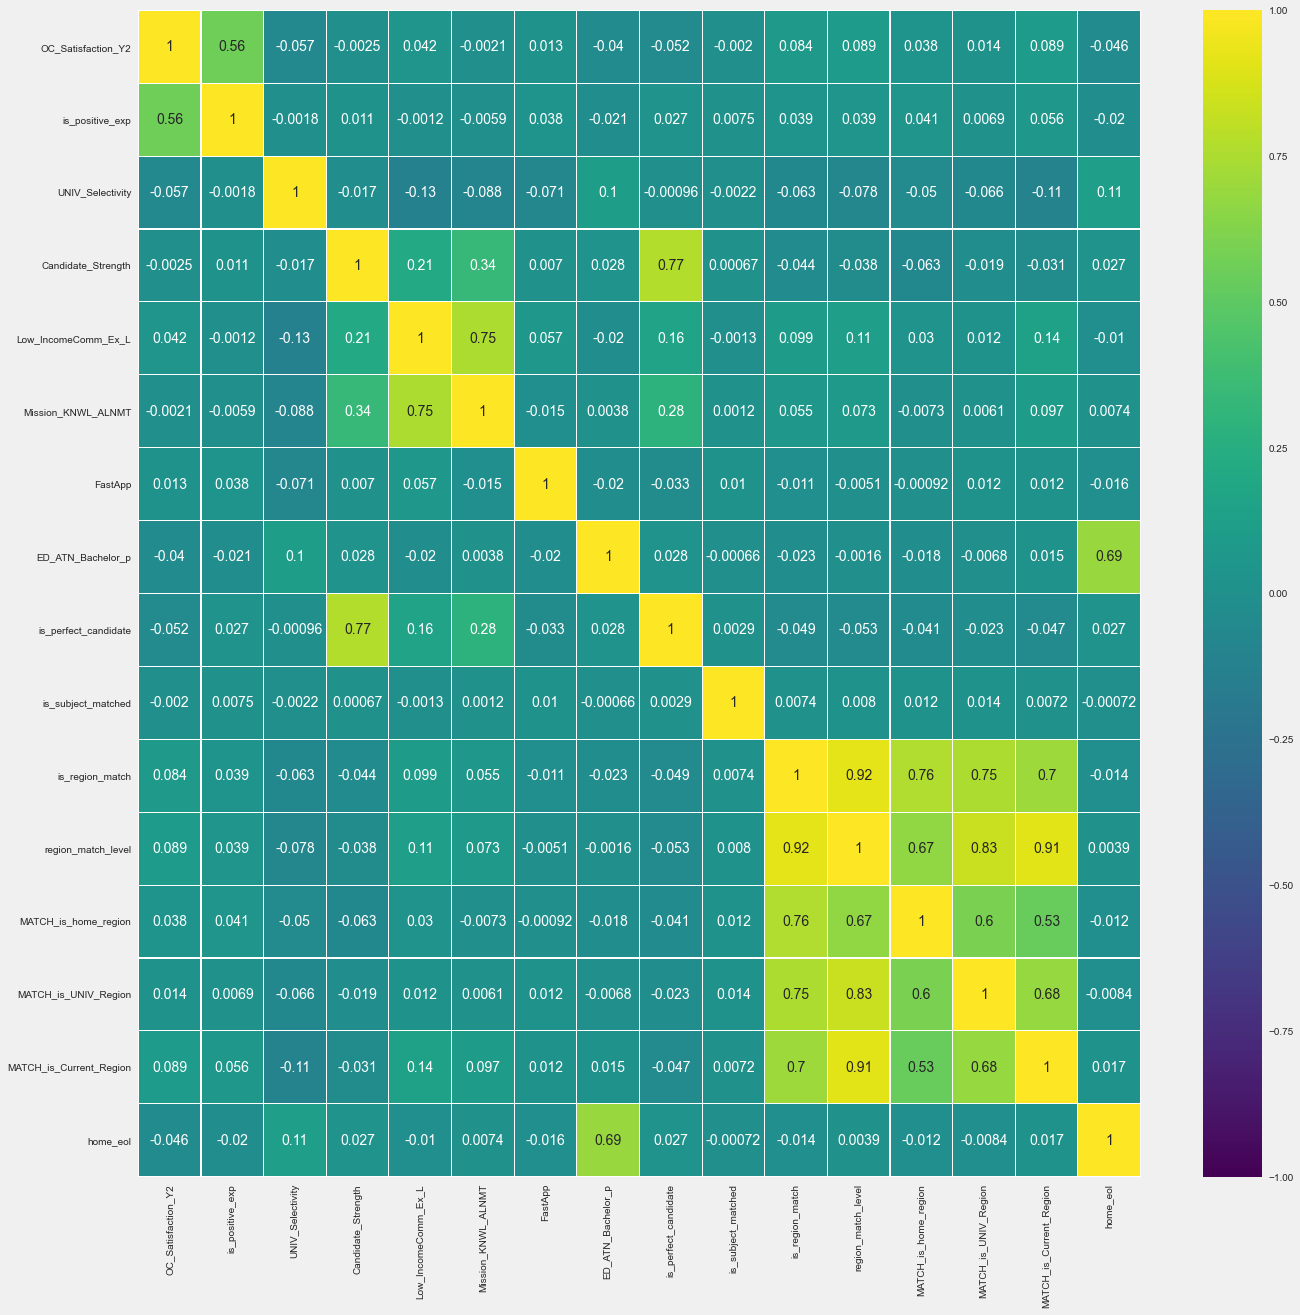

In [305]:
# Print correlation table
plt.figure(figsize=(20,20))
considered_cols = [
#     'OUTCOME_4_Complet_Y2',
    'OC_Satisfaction_Y2',
    'is_positive_exp',
    'UNIV_Selectivity',
    'Candidate_Strength',
#     'Low_IncomeComm_Ex_L',
    'Mission_KNWL_ALNMT',
#     'FastApp',
#     'ED_ATN_Bachelor_p',
#     'is_perfect_candidate',
#     'is_subject_matched',
#     'is_region_match',
    'region_match_level',
#     'MATCH_is_home_region',
    'MATCH_is_UNIV_Region',
#     'MATCH_is_Current_Region',
#     'home_eol'
]

correlation = all_data[considered_cols].corr()
sns.heatmap(correlation, vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

In [306]:
# Keep backup of all_data
all_data_backup = all_data

In [307]:
# Prepare data for model fitting
all_data = all_data_backup
wanted_outcome = 'OC_Satisfaction_Y2'

# We will just drop NAs
all_data = all_data.dropna(subset=[wanted_outcome])

labels = all_data[wanted_outcome]
features = all_data[considered_cols[2:len(considered_cols)]]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.50)

print("Train features:", len(x_train))
print("Test features:", len(x_test))

print("Train labels:", len(y_train))
print("Test labels:", len(y_test))

Train features: 45377
Test features: 45377
Train labels: 45377
Test labels: 45377


In [308]:
print ("Features na:\n", features.isna().sum())
print ("Labels na:", labels.isna().sum())

Features na:
 UNIV_Selectivity           0
Candidate_Strength         0
Low_IncomeComm_Ex_L        0
Mission_KNWL_ALNMT         0
FastApp                    0
ED_ATN_Bachelor_p          0
is_perfect_candidate       0
is_subject_matched         0
is_region_match            0
region_match_level         0
MATCH_is_home_region       0
MATCH_is_UNIV_Region       0
MATCH_is_Current_Region    0
home_eol                   0
dtype: int64
Labels na: 0


In [309]:
# plot_importances()

In [310]:
# Main function to run the model and predictions on test / training sets
def fit_model(train_features, test_features, train_labels, test_labels):
    
    test_params = {
        "n_estimators": [50, 80, 105, 130, 150],
#         "n_estimators": [130],
        "max_depth": [10, 12, 14]
#         "max_depth": [4]
    }
    
    rf = RandomForestRegressor(n_jobs = -1,
                               oob_score = True,
                               bootstrap = True,
                               random_state = 42)
    
    grid = GridSearchCV(rf, test_params, n_jobs=-1)
    grid.fit(features, labels)
    
    print("Best score:", grid.best_score_)
    print("Best params:", grid.best_params_)
    
    rf = RandomForestRegressor(n_jobs = -1,
                               n_estimators = grid.best_params_['n_estimators'],
                               max_depth = grid.best_params_['max_depth'],
                               oob_score = True,
                               bootstrap = True,
                               random_state = 42)
    
    rf.fit(features, labels)
    prediction_labels = rf.predict(test_features)
    print ("Predicition labels (outcomes) length:", len(prediction_labels))
    
     # if the training score R^2, and the validation score R^2 are far apart, then we are most likely overfitting
    print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'
          .format(rf.score(train_features, train_labels), rf.oob_score_, rf.score(test_features, test_labels)))
    
    # First way of calculating importances, default sklearn way
    importances = pd.DataFrame({'col_name': rf.feature_importances_}, index=features.columns).sort_values(by='col_name', ascending=False)
    print (importances)
    
    # Second way of checking importances (rfpimp)
    perm_imp_rfpimp = permutation_importances(rf, train_features, train_labels, r2)
    plot_importances(perm_imp_rfpimp)
    print (perm_imp_rfpimp)
    
    # Make a bar chart
    plt.style.use('fivethirtyeight')
    
    plt.figure(3)
    plt.bar(importances.index, importances.col_name, orientation = 'vertical')
    plt.xticks(importances.index, importances.index, rotation = 'vertical')
    plt.ylabel('Importance sklearn')
    
    
    # Third way of checking importants (eli5)
    perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(train_features, train_labels)
    perm_imp_eli5 = imp_df(train_features.columns, perm.feature_importances_)
    print (perm_imp_eli5)

    plt.figure(2)
    plt.bar(perm_imp_eli5.feature, perm_imp_eli5.feature_importance, orientation = 'vertical')
    plt.xticks(perm_imp_eli5.feature, perm_imp_eli5.feature, rotation = 'vertical')
    plt.ylabel('Importance')

    return prediction_labels
    
# Importance of variables for the model ( 2nd way of doing r2)
def r2(rf, train_features, train_labels):
    return r2_score(train_labels, rf.predict(train_features))

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

Best score: -0.21215370836397124
Best params: {'max_depth': 10, 'n_estimators': 105}
Predicition labels (outcomes) length: 45377
R^2 Training Score: 0.62 
OOB Score: 0.61 
R^2 Validation Score: 0.63
                         col_name
Candidate_Strength       0.605061
Mission_KNWL_ALNMT       0.117519
UNIV_Selectivity         0.102762
Low_IncomeComm_Ex_L      0.050356
FastApp                  0.040500
MATCH_is_home_region     0.027519
MATCH_is_UNIV_Region     0.024104
region_match_level       0.016099
MATCH_is_Current_Region  0.006807
is_region_match          0.005097
home_eol                 0.002793
ED_ATN_Bachelor_p        0.000842
is_perfect_candidate     0.000542
is_subject_matched       0.000000
                         Importance
Feature                            
Candidate_Strength         0.729377
UNIV_Selectivity           0.293935
Mission_KNWL_ALNMT         0.258702
MATCH_is_UNIV_Region       0.238141
region_match_level         0.155508
MATCH_is_Current_Region    0.121809
Fas

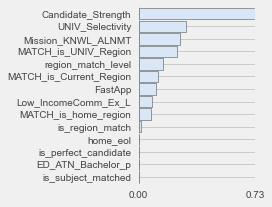

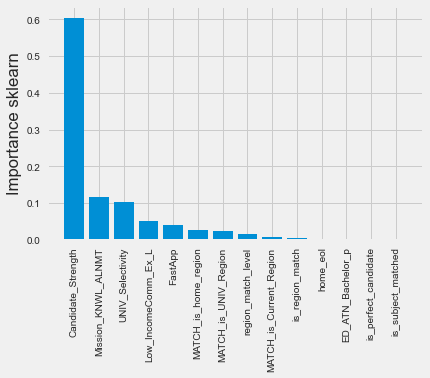

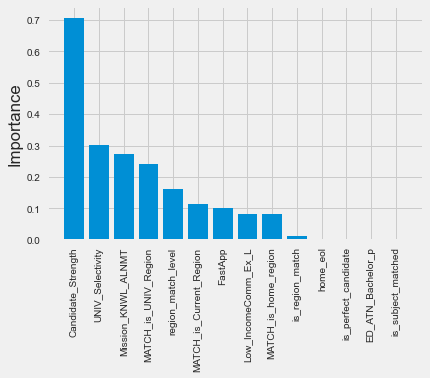

In [311]:
prediction_results = fit_model(x_train, x_test, y_train, y_test)

In [312]:
# Let's assume we have a good model ...
results = pd.concat([x_test, pd.DataFrame(y_test)], axis=1)
results['prediction_Y2_Satisfaction'] = prediction_results
results[['Candidate_Strength', 'UNIV_Selectivity', 'Mission_KNWL_ALNMT', 'MATCH_is_UNIV_Region', 'region_match_level', 'OC_Satisfaction_Y2', 'prediction_Y2_Satisfaction']].head(50)

,Candidate_Strength,UNIV_Selectivity,Mission_KNWL_ALNMT,MATCH_is_UNIV_Region,region_match_level,OC_Satisfaction_Y2,prediction_Y2_Satisfaction
12524,0.852856,3,4.0,0,1,6.50,6.463970
149324,0.823274,5,3.5,0,0,7.00,5.655645
23717,0.814630,3,4.0,1,3,5.75,5.889393
87625,0.692002,5,3.0,0,0,5.50,5.540319
75766,0.755518,4,5.0,1,3,5.75,6.029016
46228,0.801580,4,3.0,1,3,6.75,6.287900
185422,0.767673,3,5.0,1,3,5.00,5.476528
45416,0.662520,4,3.0,0,0,6.50,6.311096
73763,0.897380,4,4.0,1,3,6.00,5.847768
65842,0.788808,4,4.0,1,3,4.25,5.271440


4.800683    540
4.500665    195
6.538152    178
6.883439    133
5.585738    122
           ... 
5.970773      1
4.346483      1
5.611350      1
5.541490      1
6.095053      1
Name: prediction_Y2_Satisfaction, Length: 8458, dtype: int64

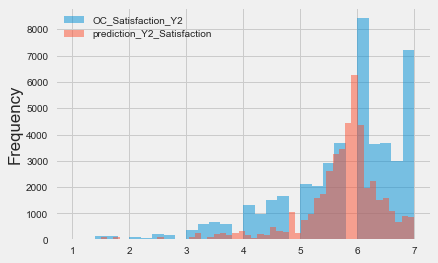

In [313]:
# We can graph the distributions of both prediction / actual values here (and we can do an After, once we split into 1/0 values)
results.OC_Satisfaction_Y2.plot(kind='hist', alpha=.5, legend=True, bins=30)
results.prediction_Y2_Satisfaction.plot(kind='hist', alpha=.5, legend=True, bins=50)

results.prediction_Y2_Satisfaction.value_counts()

6.00    8441
7.00    7203
5.75    3660
6.50    3659
6.25    3657
6.75    2995
5.50    2929
5.00    2104
5.25    2036
4.75    1679
4.50    1528
4.00    1336
4.25     982
3.50     662
3.75     618
3.25     613
3.00     355
2.50     227
2.75     184
1.75     161
1.50     126
2.00      89
2.25      68
1.00      37
1.25      28
Name: OC_Satisfaction_Y2, dtype: int64

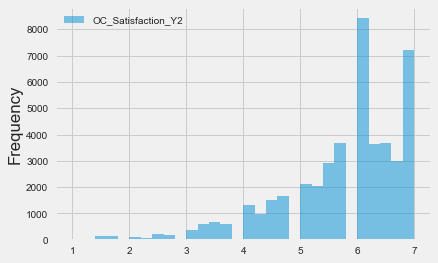

In [314]:
results.OC_Satisfaction_Y2.plot(kind='hist', alpha=.5, legend=True, bins=30)
results.OC_Satisfaction_Y2.value_counts()

In [315]:
actual_thresh = 5
predic_thresh = 5

results['OC_Satisfaction_Y2_binary'] = np.where(results.OC_Satisfaction_Y2 >= actual_thresh, 1, 0)
results['prediction_Y2_Satisfaction_binary'] = np.where(results.prediction_Y2_Satisfaction >= predic_thresh, 1, 0)
results.head(50)

,UNIV_Selectivity,Candidate_Strength,Low_IncomeComm_Ex_L,Mission_KNWL_ALNMT,FastApp,ED_ATN_Bachelor_p,is_perfect_candidate,is_subject_matched,is_region_match,region_match_level,MATCH_is_home_region,MATCH_is_UNIV_Region,MATCH_is_Current_Region,home_eol,OC_Satisfaction_Y2,prediction_Y2_Satisfaction,OC_Satisfaction_Y2_binary,prediction_Y2_Satisfaction_binary
12524,3,0.852856,3.0,4.0,0,46.200000,1,0,0,1,0,0,1,0.570000,6.50,6.463970,1,1
149324,5,0.823274,2.0,3.5,0,42.000000,1,0,0,0,0,0,0,0.573333,7.00,5.655645,1,1
23717,3,0.814630,3.0,4.0,0,38.600000,1,0,1,3,1,1,1,0.401667,5.75,5.889393,1,1
87625,5,0.692002,2.0,3.0,1,46.200000,0,0,0,0,1,0,0,0.570000,5.50,5.540319,1,1
75766,4,0.755518,3.0,5.0,0,33.500000,0,0,1,3,1,1,1,0.292222,5.75,6.029016,1,1
46228,4,0.801580,3.0,3.0,1,32.300000,1,0,1,3,1,1,1,0.224444,6.75,6.287900,1,1
185422,3,0.767673,3.0,5.0,0,47.500000,0,0,1,3,1,1,1,0.456667,5.00,5.476528,1,1
45416,4,0.662520,2.0,3.0,0,35.600000,0,0,0,0,0,0,0,0.316667,6.50,6.311096,1,1
73763,4,0.897380,3.0,4.0,0,43.000000,1,0,1,3,1,1,1,0.466667,6.00,5.847768,1,1
65842,4,0.788808,3.0,4.0,0,38.534394,0,0,1,3,1,1,1,0.494104,4.25,5.271440,0,1


1    36684
0     8693
Name: OC_Satisfaction_Y2_binary, dtype: int64
1    40320
0     5057
Name: prediction_Y2_Satisfaction_binary, dtype: int64


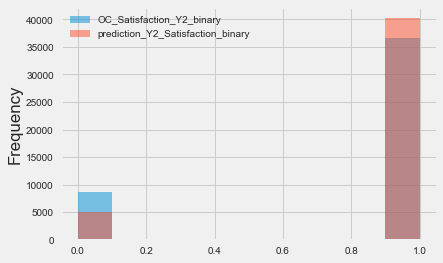

In [316]:
# We can graph the distributions of both prediction / actual values here (and we can do an After, once we split into 1/0 values)
results.OC_Satisfaction_Y2_binary.plot(kind='hist', alpha=.5, legend=True, bins=10)
results.prediction_Y2_Satisfaction_binary.plot(kind='hist', alpha=.5, legend=True, bins=10)

print (results.OC_Satisfaction_Y2_binary.value_counts())
print (results.prediction_Y2_Satisfaction_binary.value_counts())

[0.         0.44737145 1.        ]


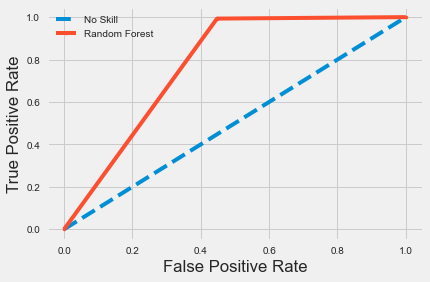

In [317]:
# Calculate values for the roc curve ...
ns_fpr, ns_tpr, th1 = roc_curve(results.OC_Satisfaction_Y2_binary, [0 for _ in range(len(results))]) # no skill curve
rf_fpr, rf_tpr, th2 = roc_curve(results.OC_Satisfaction_Y2_binary, results.prediction_Y2_Satisfaction_binary) # Regression curve

print(rf_fpr)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()